In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
# import optuna.integration.lightgbm as lgb  # 调参用
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold

import math
from collections import defaultdict
from gensim.models import Word2Vec
from tqdm import tqdm
import os
from lgb_utils import *

import joblib
import random

import warnings
warnings.filterwarnings("ignore")

tqdm.pandas(desc='pandas bar')

pd.set_option('max_columns', None)
pd.set_option('max_rows', 300)
pd.set_option('float_format', lambda x: '%.3f' % x)

tgt_market = 't2'
src_market = 's3'
tgt_data_dir = f'./DATA/{tgt_market}/'
src_data_dir = f'./DATA/{src_market}/'

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
train = pd.read_table(tgt_data_dir+'train.tsv')
train_5core = pd.read_table(tgt_data_dir+'train_5core.tsv')
# train_semi = pd.read_csv(tgt_data_dir+'train_semi.csv')

train_cross = train_5core.merge(train, on=['userId', 'itemId'], how='left')
train_5core = train_cross[train_cross['rating_y'].isnull()][['userId', 'itemId']]  

train = pd.concat([train, train_5core, train_5core, train_5core, train_5core, train_5core], ignore_index=True)
print(train.shape)

# s1数据
train_s1 = pd.read_table(src_data_dir+'train.tsv')
train_5core_s1 = pd.read_table(src_data_dir+'train_5core.tsv')

train_cross_s1 = train_5core_s1.merge(train, on=['userId', 'itemId'], how='left')
train_5core_s1 = train_cross_s1[train_cross_s1['rating_y'].isnull()][['userId', 'itemId']]

train_s1 = pd.concat([train_s1, train_5core_s1, train_5core_s1, train_5core_s1, train_5core_s1, train_5core_s1], ignore_index=True)

(128075, 3)


In [3]:
train.head()

,userId,itemId,rating
0,t2U1008825,P1014064,5.000
1,t2U1000444,P1011611,1.000
2,t2U1014700,P1028053,5.000
3,t2U1011417,P1018377,4.000
4,t2U1014369,P1020825,5.000


# 提取用户侧和物品侧的特征

In [4]:
# 转成列表
user_feature_list = train.groupby("userId").agg(item_list=("itemId", list), rating_list=("rating", list)).reset_index()
item_feature_list = train.groupby("itemId").agg(user_list=("userId", list), rating_list=("rating", list)).reset_index()

# 构建训练集和测试集

## 构建验证集&测试集

In [5]:
def load_market_valid_run(valid_run_file):  # 把一行item_id分别拆到user_id中,构成<user_id,item_id>pair
    users, items = [], []
    with open(valid_run_file, 'r') as f:
        for line in f:
            linetoks = line.split('\t')
            user_id = linetoks[0]
            item_ids = linetoks[1].strip().split(',')
            for cindex, item_id in enumerate(item_ids):
                users.append(user_id)
                items.append(item_id)

    return users, items

# 提取特征
user_feature, item_feature = get_static_feat(train.copy(), user_feature_list.copy(), item_feature_list.copy())  # 统计特征
user_embed = emb(train.copy(), 'userId', 'itemId', tgt_market, mode='agg')                                      # embed特征
item_embed = emb(train.copy(), 'userId', 'itemId', tgt_market, mode='single')                                   # embed特征
user_tfidf, item_tfidf = get_tfidf(user_feature_list.copy(), item_feature_list.copy())                          # tfidf特征
#########################################验证集#########################################
user_ids, item_ids = load_market_valid_run(tgt_data_dir+'valid_run.tsv')
# valid_semi = pd.read_csv(tgt_data_dir+'valid_semi.csv')
# valid_semi['label'] = 1
valid = pd.DataFrame(columns=['userId','itemId'])
valid['userId'] = user_ids
valid['itemId'] = item_ids
# 把label merge上去
valid_qrel = pd.read_table(tgt_data_dir+'valid_qrel.tsv').rename({'rating':'label'}, axis=1)
valid = valid.merge(valid_qrel, how='left', on=['userId','itemId'])
valid['label'] = valid['label'].fillna(0)
# valid = pd.concat([valid, valid_semi], ignore_index=True)
# 合并统计特征
valid = valid.merge(user_feature, on='userId',how='left')
valid = valid.merge(item_feature, on='itemId',how='left')
# 合并w2v特征
valid = valid.merge(user_embed, on='userId',how='left')
valid = valid.merge(item_embed, on='itemId',how='left')
# 合并item的tfidf特征
valid = valid.merge(item_tfidf, on='itemId',how='left')

#########################################测试集#########################################
user_ids, item_ids = load_market_valid_run(tgt_data_dir+'test_run.tsv')
test = pd.DataFrame(columns=['userId','itemId'])
test['userId'] = user_ids
test['itemId'] = item_ids
# 合并统计特征
test = test.merge(user_feature, on='userId',how='left')
test = test.merge(item_feature, on='itemId',how='left')
# 合并w2v特征
test = test.merge(user_embed, on='userId',how='left')
test = test.merge(item_embed, on='itemId',how='left')
# 合并tfidf特征
test = test.merge(item_tfidf, on='itemId',how='left')

# 合并嫁接学习分数特征 
# transfer_feat_s1 = pd.read_csv(f'./transfer_data/s1_{tgt_market}_guide.csv')   # 超级过拟合
transfer_feat_s1 = pd.read_csv(f'./transfer_data/s1_{tgt_market}_transfer.csv')
# transfer_feat_s2 = pd.read_csv(f'./transfer_data/s2_{tgt_market}_transfer.csv')
# transfer_feat_s3 = pd.read_csv(f'./transfer_data/s3_{tgt_market}_transfer.csv')

valid = valid.merge(transfer_feat_s1, on=['userId', 'itemId'],how='left')
test = test.merge(transfer_feat_s1, on=['userId', 'itemId'],how='left')

# valid = valid.merge(transfer_feat_s2, on=['userId', 'itemId'],how='left')
# test = test.merge(transfer_feat_s2, on=['userId', 'itemId'],how='left')

# valid = valid.merge(transfer_feat_s3, on=['userId', 'itemId'],how='left')
# test = test.merge(transfer_feat_s3, on=['userId', 'itemId'],how='left')

# 

find w2v model
find w2v model


In [6]:
# 合并item_cf特征
valid_cf = get_sim_feature(train.copy(), valid.copy())
test_cf = get_sim_feature(train.copy(), test.copy())
valid = valid.merge(valid_cf, how='left', on=['userId','itemId'])
test = test.merge(test_cf, how='left', on=['userId','itemId'])
print(valid.shape)
# 从source市场中获取item_cf特征
# valid_cf_s = get_source_item_cf(train.copy(), train_s1.copy(), valid.copy())
# test_cf_s = get_source_item_cf(train.copy(), train_s1.copy(), test.copy())
# valid = valid.merge(valid_cf_s, how='left', on=['userId','itemId'])
# test = test.merge(test_cf_s, how='left', on=['userId','itemId'])

100%|██████████| 8919/8919 [00:00<00:00, 29076.20it/s]


(602317, 101)


In [7]:
# # 合并deepwalk特征
# deepwalk_emb = pd.read_csv(f'./deepwalk_{tgt_market}.csv')
# # valid = valid.merge(deepwalk_emb.rename({'id':'userId'}, axis=1), how='left', on='userId')
# valid = valid.merge(deepwalk_emb.rename({'id':'itemId'}, axis=1), how='left', on='itemId')

# # test = test.merge(deepwalk_emb.rename({'id':'userId'}, axis=1), how='left', on='userId')
# test = test.merge(deepwalk_emb.rename({'id':'itemId'}, axis=1), how='left', on='itemId')

# 训练&预测

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[141]	training's auc: 0.952595	training's binary_logloss: 0.0237715	valid_1's auc: 0.897779	valid_1's binary_logloss: 0.0281655
Fold  1 AUC : 0.897779
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's auc: 0.939091	training's binary_logloss: 0.0253519	valid_1's auc: 0.896491	valid_1's binary_logloss: 0.0273258
Fold  2 AUC : 0.896491
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	training's auc: 0.95005	training's binary_logloss: 0.02412	valid_1's auc: 0.892879	valid_1's binary_logloss: 0.0279697
Fold  3 AUC : 0.892879
=====Full AUC score 0.895640=====


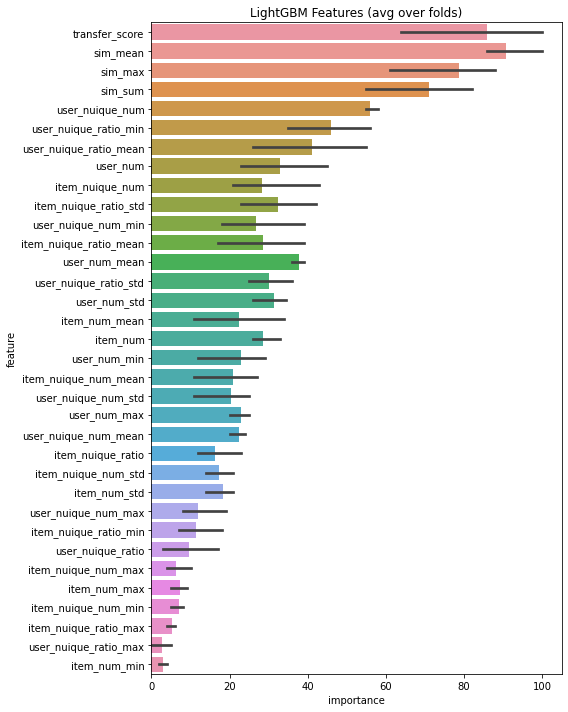

In [8]:
train = valid
y = train['label']
folds = KFold(n_splits=3, shuffle=True, random_state=546789)
s_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=546789)
oof_preds, test_preds, importances = train_model_lgb(train, test, y, s_folds)

importances = importances[~importances['feature'].str.contains('emb')]
display_importances(importances)

In [9]:
run_dir = './baseline_outputs/sample_run/'

In [10]:
test_preds.sort_values(by=['userId', 'score'], ascending=[True, False], inplace=True)
oof_preds.sort_values(by=['userId', 'score'], ascending=[True, False], inplace=True)

# 低置信度使用热度item填充
# 验证集
# vaild_qrel = pd.read_table(tgt_data_dir+'valid_qrel.tsv')    # 真实交互
# valid_run = pd.read_csv(tgt_data_dir+'valid_run.tsv', sep='\t', header=None) # 验证样本
# valid_run.columns = ['userId','itemIds']
# vaild_hot_result, error_list = get_hot_reslut(vaild_qrel.copy(), oof_preds.copy(), valid_run.copy(), train.copy())
# oof_preds = pd.concat([vaild_hot_result, oof_preds[~oof_preds['userId'].isin(error_list)]], ignore_index=True)

# # 测试集
# test_run = pd.read_csv(tgt_data_dir+'test_run.tsv', sep='\t', header=None) # 验证样本
# test_run.columns = ['userId','itemIds']
# test_hot_result, error_list = get_hot_reslut(vaild_qrel.copy(), oof_preds.copy(), test_run.copy(), train.copy())
# test_preds = pd.concat([test_hot_result, test_preds[~test_preds['userId'].isin(error_list)]], ignore_index=True)


test_preds.to_csv(run_dir+f'{tgt_market}/test_pred.tsv', sep='\t', index=False)
oof_preds.to_csv(run_dir+f'{tgt_market}/valid_pred.tsv', sep='\t', index=False)

In [11]:
# 保存置信度高的结果用于训练
# test_preds[test_preds['score']>0.95][['userId', 'itemId']].to_csv(tgt_data_dir+'valid_semi.csv', index=None)

### 使用item热度填充在valid中预测位置超过10的user的item列表